# Categorical Model Dedicated Notebook

## Data Admin:

15795
15795
Loaded images on average at 166.99708768597657us
Calculated angles on average at 23.90553972776195us
31590
31590
(31590, 50, 50, 3)
17787


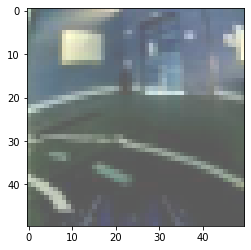

[1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [47]:
import os
import natsort
import numpy as np
import cv2
import json
import tensorflow as tf
from random import randrange
import datetime 

import matplotlib.pyplot as plt

%matplotlib inline

#finding and sorting images and label data: - Unthresholded Images!
path = 'halldatarecords2/'

im_list = []

rec_list = []

for file in os.listdir(path):
    if 'cam' in file:
        im_list.append(file)
    elif 'record' in file:
        rec_list.append(file)

        
print(len(im_list))
print(len(rec_list))

im_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
rec_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#reading in array of images:
width = 50#160
height = 50#120
color = 3
#x_images = np.zeros((len(rec_list), 120, 160, 3), dtype = np.float32)
x_images = np.zeros((len(rec_list)*2, height, width, color), dtype = np.float32)

randomImage = randrange(len(x_images))#14909
preprocessDelta = np.zeros(len(rec_list), dtype = np.uint8)
for i in range(len(im_list)):
    start = datetime.datetime.now()
    filename = im_list[i]
    image = cv2.imread(path+filename)
    image = cv2.resize(image,(height,width),interpolation = cv2.INTER_AREA)
    beta = 100-(np.average(image)/255)*100
    image = cv2.convertScaleAbs(image, alpha=1.0, beta=beta)    
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,11,2)
    image = image.astype('uint8')
    #image = image[..., None]
    #x_images[i,:,:,:] = tf.cast(image[..., None], tf.float32)
    x_images[i,:,:,:] = tf.cast(image, tf.float32)
    #x_images[i+len(rec_list),:,:,:] = tf.cast(cv2.flip(image, 1)[..., None], tf.float32)
    x_images[i+len(rec_list),:,:,:] = tf.cast(cv2.flip(image, 1), tf.float32)
    end = datetime.datetime.now()
    preprocessDelta[i] = (end-start).microseconds
    
def getAngle(orient):
    angle = [0,0,0,0,0,0,0,0,0]
    if orient > (35.0/45.0):
        angle = [0,0,0,0,0,0,0,0,1] #35+ right
    elif orient > (25.0/45.0):
        angle = [0,0,0,0,0,0,0,1,0] #25+ right
    elif orient > (15.0/45.0):
        angle = [0,0,0,0,0,0,1,0,0] #15+ right
    elif orient > (5.0/45.0):
        angle = [0,0,0,0,0,1,0,0,0] #5+ right
    elif orient < -1*(35.0/45.0):
        angle = [1,0,0,0,0,0,0,0,0] #35+ left
    elif orient < -1*(25.0/45.0):
        angle = [0,1,0,0,0,0,0,0,0] #25+ left
    elif orient < -1*(15.0/45.0):
        angle = [0,0,1,0,0,0,0,0,0] #15+ left
    elif orient < -1*(5.0/45.0):
        angle = [0,0,0,1,0,0,0,0,0] #5+ left
    else:
        angle = [0,0,0,0,1,0,0,0,0] #0 straight
    return angle
        
print(f'Loaded images on average at {np.average(preprocessDelta)}us')
#loop over labels and create a list of left/right/straight based on a degree threshold (one-hot encoding?)
json_data = {}
#y_labels = np.zeros((len(rec_list),3), dtype=np.float32) #setup label array for one-hot encoded left, right and straight
y_labels = np.zeros((len(rec_list)*2,9), dtype=np.float32)
#[-35,-25,-15,-5,0,5,15,25,35]
for i in range(len(rec_list)):
    start = datetime.datetime.now()
    filename = rec_list[i]
    with open(path+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        orient = float(orient)
        y_labels[i] = getAngle(orient)
        y_labels[i+len(rec_list)] = getAngle(-1*orient)
    end = datetime.datetime.now()
    preprocessDelta[i] = (end-start).microseconds
            
print(f'Calculated angles on average at {np.average(preprocessDelta)}us')
print(len(x_images))
print(len(y_labels))
print(x_images.shape)
print(randomImage)
plt.imshow(x_images[randomImage].astype('uint8'))
plt.show()
print(y_labels[randomImage])

(31590, 9)
700
1700
2700
3700
4700
5700
6700
7700
8700
9700
10700
11700
12700
13700
14700
15700
16700
17700
18700
19700
20700
21700
22700
23700
24700
25700
26700
27700
28700
29700
30700
(22114, 50, 50, 3)
(9478, 50, 50, 3)
(22114, 9)
(9478, 9)
[0. 0. 0. 0. 1. 0. 0. 0. 0.]


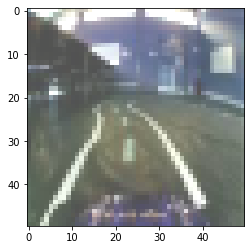

In [48]:
#training and validation split:

memv = 0
memt = 0
x_val = np.zeros((round(len(x_images)*0.3)+1,height, width, color), dtype=np.float32)
x_train = np.zeros((round(len(x_images)*0.7)+1,height, width, color), dtype=np.float32)
#y_val = np.zeros((round(len(x_images)*0.3)+1,3), dtype=np.float32)
#y_train = np.zeros((round(len(x_images)*0.7)+1,3), dtype=np.float32)
y_val = np.zeros((round(len(x_images)*0.3)+1,9), dtype=np.float32)
y_train = np.zeros((round(len(x_images)*0.7)+1,9), dtype=np.float32)

n=0
print(y_labels.shape)

for i in range(len(x_images)):
    if (i>=1000)and(i % 1000 == 0):
        j = i - 300
        k = i - 1000
        print(j)
        o = 0
        p = 0
        for l in range(0+n*300, n*300+300):
            #x_val[l] = x_images[j+o,:,:,:]
            x_val[l] = x_images[j+o,:,:,:]
            y_val[l] = y_labels[j+o]
            o +=1
        for m in range(0+n*700, n*700+700):
            #x_train[m] = x_images[k+p,:,:,:]
            x_train[m] = x_images[k+p,:,:,:]
            y_train[m] = y_labels[k+p]
            p+=1
        n+=1
        
print(x_train.shape)
print(x_val.shape)

print(y_train.shape)
print(y_val.shape)

print(y_val[1000])
plt.imshow(x_val[1000].astype('uint8'))
plt.show()
#obtaining test data

#relabeling test data

## Model Setup:

In [50]:
import os
import numpy as np

from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Cropping2D, Lambda

#Model Structure Setup: no dropout, no regularization yet

#model = ''
model = Sequential()
#model.add(Convolution2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(120, 160, 3)))
#Number of feature maps
#Kernel size matrix (thing that looks at picture)
#Strides is how kernel moves accross the image
#Activation is activation algorithm
#Input shape is the image
model.add(Convolution2D(32, (5,5), strides=(3,3), activation='relu', input_shape=(height, width, color)))
model.add(Convolution2D(64, (5,5), strides=(5,5), activation='relu'))
model.add(Convolution2D(64, (3,3), strides=(2,2), activation='relu'))
#model.add(Convolution2D(128, (2,2), strides=(1,1), activation='relu'))
#model.add(Convolution2D(128, (2,2), strides=(1,1), activation='relu'))
model.add(Flatten())
#model.add(Dense(256, activation='relu'))#Arbitrary 
#model.add(Dense(128, activation='relu'))#Arbitrary 
#model.add(Dense(64, activation='relu'))#Arbitrary
model.add(Dense(32, activation='relu'))#Arbitrary 
model.add(Dense(9, activation='softmax'))

model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 16, 16, 32)        2432      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 3, 3, 64)          51264     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_11 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 9)                 297       
Total params: 93,001
Trainable params: 93,001
Non-trainable params: 0
_________________________________________________

## Training and Validation:

In [51]:
history = model.fit(x_train/255.0, y_train, epochs=10, batch_size=200, validation_data=(x_val/255.0, y_val), shuffle=True, verbose=1)

Train on 22114 samples, validate on 9478 samples
Epoch 1/10
22114/22114 [==============================] - 6s 267us/sample - loss: 1.6320 - accuracy: 0.3905 - val_loss: 1.3681 - val_accuracy: 0.4359
Epoch 2/10
22114/22114 [==============================] - 5s 239us/sample - loss: 1.2297 - accuracy: 0.5217 - val_loss: 1.3110 - val_accuracy: 0.4572
Epoch 3/10
22114/22114 [==============================] - 5s 239us/sample - loss: 1.2467 - accuracy: 0.5075 - val_loss: 1.3875 - val_accuracy: 0.4575
Epoch 4/10
22114/22114 [==============================] - 5s 246us/sample - loss: 1.2222 - accuracy: 0.5197 - val_loss: 1.3283 - val_accuracy: 0.4725
Epoch 5/10
22114/22114 [==============================] - 6s 259us/sample - loss: 1.1472 - accuracy: 0.5399 - val_loss: 1.2767 - val_accuracy: 0.4560
Epoch 6/10
22114/22114 [==============================] - 6s 275us/sample - loss: 1.1207 - accuracy: 0.5491 - val_loss: 1.2938 - val_accuracy: 0.4658
Epoch 7/10
22114/22114 [===========================

In [52]:
# Let's Evaluate
test_loss, test_acc = model.evaluate(x_val/255.0,  y_val, verbose=2)
print(test_acc)

9478/1 - 1s - loss: 0.6379 - accuracy: 0.4787
0.4786875


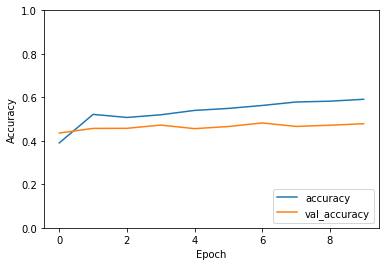

In [53]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

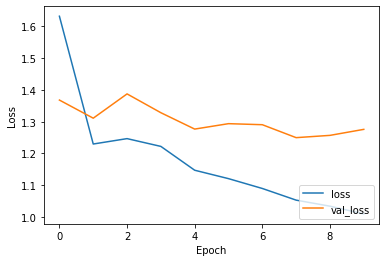

In [54]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

Expected
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
Predicted
[0. 0. 0. 0. 1. 0. 0. 0. 0.]


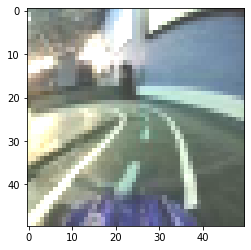

Expected
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted
[1. 0. 0. 0. 0. 0. 0. 0. 0.]


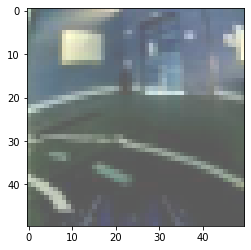

Expected
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted
[1. 0. 0. 0. 0. 0. 0. 0. 0.]


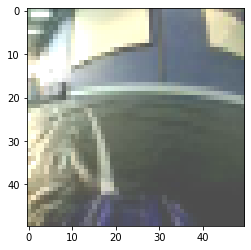

In [55]:
out = model.predict(x_images/255.0, batch_size=200)
out = np.around(out)

pointOne = randomImage
pointTwo = randomImage
pointThree = randomImage

if randomImage >= 100:
    pointOne = randomImage - 100
else:
    pointOne = 0
    
if randomImage <= len(x_images) + 100:
    pointThree = randomImage + 100
else:
    pointThree = len(x_images)

#if round(out[pointOne,0]) == 1:
#    print('left')
#elif round(out[pointOne, 1]) == 1:
#    print('straight')
#elif round(out[pointOne, 2]) == 1:
#    print('right')
print('Expected')
print(y_labels[pointOne])
print('Predicted')
print(out[pointOne])
plt.imshow(x_images[pointOne].astype('uint8'))
plt.show()

#if round(out[pointTwo,0]) == 1:
#    print('left')
#elif round(out[pointTwo, 1]) == 1:
#    print('straight')
#elif round(out[pointTwo, 2]) == 1:
#    print('right')
print('Expected')
print(y_labels[pointTwo])
print('Predicted')
print(out[pointTwo])
plt.imshow(x_images[pointTwo].astype('uint8'))
plt.show()

#if round(out[pointThree,0]) == 1:
#    print('left')
#elif round(out[pointThree, 1]) == 1:
#    print('straight')
#elif round(out[pointThree, 2]) == 1:
#    print('right')
print('Expected')
print(y_labels[pointThree])
print('Predicted')
print(out[pointThree])
plt.imshow(x_images[pointThree].astype('uint8'))
plt.show()